This NB explores burn vs. shortfall for a given shortfall_fraction, the various miner metrics

In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib notebook

In [2]:
from shortfall.sim import Simulator, SimConfig
from shortfall.miners.repay_proportional import RepayProportionalShortfallMinerState
from shortfall.miners.burn import BurnShortfallMinerState
from shortfall.miners.repay_ratchet import RepayRatchetShortfallMinerState
from shortfall.miners.base import BaseMinerState
# from shortfall.network import *
from shortfall.network import REWARD_DECAY, BASELINE_GROWTH
from shortfall.network_mechafil import DEFAULT_NETWORK_CONFIG
from shortfall.network_mechafil import NetworkConfig as MechafilNetworkConfig
from shortfall.network_mechafil import NetworkState as MechafilNetworkState
from shortfall.network_mechafil import compute_mechafil_trajectories
from shortfall.strategy import *
from shortfall.consts import *
import shortfall.gradient.wrappers as wrappers

import dataclasses
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import matplotlib as mpl

from datetime import date, timedelta

from mpl_toolkits.axes_grid1 import make_axes_locatable
import pickle
from tqdm.auto import tqdm
from ipywidgets import *

In [3]:
days = 3 * YEAR + 1
stats_interval = DAY

In [4]:
today_minus_two_days = date.today() - timedelta(days=2)
low_rbp = 3
ob_low_sa_low = compute_mechafil_trajectories(
    '/Users/kiran/code/filecoin-mecha-twin/kiran_spacescope_auth.json',
    start_date=today_minus_two_days,
    network_shortfall_rate=0.2,
    simulation_len=days+1,
    rbp=low_rbp,
    rr=0.6,
    fpr=0.8,
    sector_duration=360
)

med_rbp = 6
ob_med_sa_low = compute_mechafil_trajectories(
    '/Users/kiran/code/filecoin-mecha-twin/kiran_spacescope_auth.json',
    start_date=today_minus_two_days,
    network_shortfall_rate=0.2,
    simulation_len=days+1,
    rbp=med_rbp,
    rr=0.6,
    fpr=0.8,
    sector_duration=360
)

hi_rbp = 15
ob_hi_sa_low = compute_mechafil_trajectories(
    '/Users/kiran/code/filecoin-mecha-twin/kiran_spacescope_auth.json',
    start_date=today_minus_two_days,
    network_shortfall_rate=0.2,
    simulation_len=days+1,
    rbp=hi_rbp,
    rr=0.6,
    fpr=0.8,
    sector_duration=360
)

Computing mechafil trajectories


/opt/anaconda3/envs/cel/lib/python3.10/site-packages/pandas/core/ops/array_ops.py:73: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior. In a future version these will be considered non-comparable. Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
  result = libops.scalar_compare(x.ravel(), y, op)
/opt/anaconda3/envs/cel/lib/python3.10/site-packages/pandas/core/ops/array_ops.py:73: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior. In a future version these will be considered non-comparable. Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
  result = libops.scalar_compare(x.ravel(), y, op)


Finished computing mechafil trajectories
Computing mechafil trajectories


/opt/anaconda3/envs/cel/lib/python3.10/site-packages/pandas/core/ops/array_ops.py:73: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior. In a future version these will be considered non-comparable. Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
  result = libops.scalar_compare(x.ravel(), y, op)
/opt/anaconda3/envs/cel/lib/python3.10/site-packages/pandas/core/ops/array_ops.py:73: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior. In a future version these will be considered non-comparable. Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
  result = libops.scalar_compare(x.ravel(), y, op)


Finished computing mechafil trajectories
Computing mechafil trajectories


/opt/anaconda3/envs/cel/lib/python3.10/site-packages/pandas/core/ops/array_ops.py:73: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior. In a future version these will be considered non-comparable. Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
  result = libops.scalar_compare(x.ravel(), y, op)
/opt/anaconda3/envs/cel/lib/python3.10/site-packages/pandas/core/ops/array_ops.py:73: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior. In a future version these will be considered non-comparable. Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
  result = libops.scalar_compare(x.ravel(), y, op)


Finished computing mechafil trajectories


In [5]:
# # def get_base_raw_income(network_config, power, shortfall_amt = 0.0):
# #     base_strategy = StrategyConfig.power_limited(power * TIBIBYTE / EXBIBYTE, 3 * YEAR, shortfall_amt)
# #     base_miner_factory = BaseMinerState.factory(balance=0)
# #     baseline_cfg = SimConfig(
# #         network=network_config,
# #         strategy=base_strategy,
# #         miner_factory=base_miner_factory,
# #     )
# #     base_stats = Simulator(baseline_cfg).run_all(days, stats_interval)
# #     return base_stats

# def get_base_apy_model_income(base_stats, pledge_borrowed, 
#                               borrow_cost_aer=.25):
#     # apply cost model(s) on top of this
#     income_apy_model = bcm.compute_income_borrow_apy(
#         base_stats, 
#         pledge_borrowed,
#         apy=borrow_cost_aer, 
#         sampling_rate_days=1)
#     borrow_apy_income = np.array(income_apy_model)
    
#     return borrow_apy_income

# def get_revenue_take_model_income(base_stats, pledge_borrowed, 
#                                   repayment_cap=1.4, take_rate=0.40):
#     income_take_rewards_model, repay_remaining_vector = bcm.compute_income_take_rewards(
#         base_stats,
#         pledge_borrowed,
#         repayment_cap=repayment_cap,
#         take_rate=take_rate,
#         sampling_rate_days=1
#     )
#     take_rewards_income = np.array(income_take_rewards_model)
#     repay_remaining_vector = np.array(repay_remaining_vector)
    
#     return take_rewards_income, repay_remaining_vector

# def get_burn_stats(network_config, max_shortfall_possible, power, shortfall_pct_pow, 
#                    shortfall_frac=0.0, miner_balance=0):
#     """
#     max_shortfall_possible - the maximum amount of shortfall that is possible at the protocol level
#     shortfall_frac - a value between [0,max_shortfall_possible] that is the shortfall to take
#     token_lease_fee - the borrowing rate for the tokens that are not acquired through shortfall
#     """
#     burn_miner_factory = BurnShortfallMinerState.factory(balance=miner_balance, 
#                                                          max_shortfall_fraction=max_shortfall_possible,
#                                                          shortfall_take_rate_exponent=shortfall_pct_pow)

#     burn_pl_cfg = SimConfig(
#         network=network_config,
#         strategy=StrategyConfig.power_limited(power * TIBIBYTE / EXBIBYTE, days, shortfall_frac),
#         miner_factory=burn_miner_factory,
#     )
#     stats_burn = Simulator(burn_pl_cfg).run_all(days, stats_interval)
#     return pd.DataFrame(data=stats_burn)

# def get_repay_stats(network_config, miner_balance, power, max_fee_reward_fraction, shortfall_take_amount):
#     max_repayment_term = 3. * 365 * DAY
#     repay_miner_factory = RepayRatchetShortfallMinerState.factory(
#         balance=miner_balance,
#         max_repayment_term=max_repayment_term,
#         max_fee_reward_fraction=max_fee_reward_fraction,
#         reward_projection_decay=REWARD_DECAY + BASELINE_GROWTH
#     )

#     repay_cfg = SimConfig(
#         network=network_config,
#         strategy=StrategyConfig.power_limited(power * TIBIBYTE / EXBIBYTE, days, shortfall_take_amount),
#         miner_factory=repay_miner_factory,
#     )
#     stats_repay = Simulator(repay_cfg).run_all(days, stats_interval)
#     return pd.DataFrame(data=stats_repay)

In [6]:
# global config
delta=0.1
shortfall_frac_vec = np.arange(0.0,0.4+delta,delta)

miner_balance=0
token_lease_fee=0.0
power = 50  # noop

# burn config
max_shortfall_possible = 0.5  # noop
shortfall_pct_pow_vec = np.linspace(0,1,5)

# repay config
max_fee_reward_fraction_vec = np.arange(0.1,0.2+.02,.02)

# setup network configs
low_onboarding_network_config = \
    dataclasses.replace(DEFAULT_NETWORK_CONFIG, 
                        cil_df=ob_low_sa_low,
                        token_lease_fee=0.0)

medium_onboarding_network_config = \
    dataclasses.replace(DEFAULT_NETWORK_CONFIG, 
                        cil_df=ob_med_sa_low,
                        token_lease_fee=0.0)

high_onboarding_network_config = \
    dataclasses.replace(DEFAULT_NETWORK_CONFIG, 
                        cil_df=ob_hi_sa_low,
                        token_lease_fee=0.0)

In [8]:
burn_with_shortfall_results = {}
repay_with_shortfall_results = {}
base_apy_results = {}
base_takerewards_results = {}
base_no_cost_results = {}
external_borrow_rate_aer = .25
repayment_cap=1.5
take_rate=0.40

rbp_onboard_vec = [3,6,15]
networking_config_vec = [low_onboarding_network_config, medium_onboarding_network_config, high_onboarding_network_config]

pbar = tqdm(total=len(shortfall_frac_vec)*len(networking_config_vec))
for rbp_onboard, network_config in zip(rbp_onboard_vec, networking_config_vec):
    key = '%0.02f' % (rbp_onboard, )
    base_free = wrappers.compute_baseline(network_config, power, sector_duration=days, shortfall_frac=0.0)
    base_no_cost_results[key] = pd.DataFrame(data=base_free)
                                    
    for shortfall_frac in shortfall_frac_vec:
        # can be done on the fly
#         full_balance_needed = base_free[0]['balance'] + base_free[0]['pledge_locked']
#         shortfall_amt = full_balance_needed*shortfall_frac
#         print(rbp_onboard, shortfall_frac, full_balance_needed,shortfall_amt)
#         key = '%0.02f,%0.02f,%0.02f' % (rbp_onboard,shortfall_frac,external_borrow_rate_aer)
#         borrow_apy_income = get_base_apy_model_income(base_free, shortfall_amt, 
#                                                       external_borrow_rate_aer)
#         base_apy_results[key] = borrow_apy_income
#         key = '%0.02f,%0.02f,%0.02f,%0.02f' % (rbp_onboard,shortfall_frac,repayment_cap,take_rate)
#         borrow_rewardstake_income, _ = get_revenue_take_model_income(base_free, shortfall_amt, 
#                                                                   repayment_cap, take_rate)
#         base_takerewards_results[key] = borrow_rewardstake_income
        
        
        for shortfall_pct_pow in shortfall_pct_pow_vec:
            # set token lease fee to 0, this simulates the scenario where the remainder of the tokens
            # needed for pledge come from the miner's wallet
            key = '%0.02f,%0.02f,%0.02f' % (rbp_onboard,shortfall_pct_pow, shortfall_frac)
            burn_with_shortfall_df = wrappers.get_burn_stats(
                network_config, 
                power=power, 
                max_shortfall_possible=max_shortfall_possible, 
                shortfall_pct_pow=shortfall_pct_pow,
                sector_duration=days,
                shortfall_frac=shortfall_frac,
                miner_balance=0,
                network_uptake=0,
                fee_structure='linear',  # a noop
                max_fee_frac=0
            )
#             burn_with_shortfall_df = get_burn_stats(network_config, 
#                                                     max_shortfall_possible, power, shortfall_pct_pow, 
#                                                     shortfall_frac)
            burn_with_shortfall_results[key] = burn_with_shortfall_df

        pbar.update(1)

  0%|          | 0/15 [00:00<?, ?it/s]

<IPython.core.display.Javascript object>


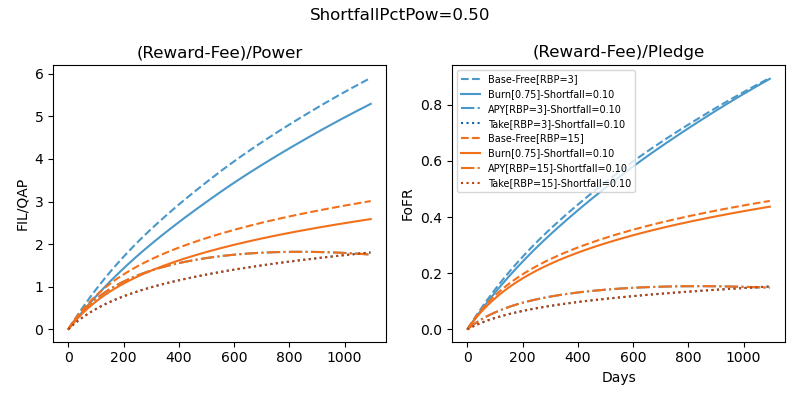

interactive(children=(FloatSlider(value=0.5, description='shortfall_pct_pow', max=1.0, step=0.25), Output()), …

<function __main__.update(shortfall_pct_pow=0.5)>

In [16]:
savedir='/Users/kiran/Documents/hackmd/shortfall'
os.makedirs(savedir, exist_ok=True)
colors = [mpl.colormaps['Blues'], mpl.colormaps['Oranges'], mpl.colormaps['Greens'], mpl.colormaps['Purples']]
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(8,4))

# def get_income(df):
#     return df.iloc[1:]['reward_earned'] - df.iloc[1:]['fee_burned'] - df.iloc[1:]['lease_fee_accrued'] 

power = 50
linestyles=['-', ':', '--', '-.']
def update(shortfall_pct_pow=0.5):
    ax[0].cla()
    ax[1].cla()
    
    for jj, rbp in enumerate([3,15]):
        base_no_cost = base_no_cost_results['%0.02f' % (rbp,)]
        #base_no_cost_income = base_no_cost['reward_earned']-base_no_cost['fee_burned']
        base_no_cost_income = wrappers.get_income(base_no_cost)
        ax[0].plot(base_no_cost_income/power, color=colors[jj](0.6), linestyle='--', label='Base-Free[RBP=%d]' % (rbp,))
        ax[1].plot(base_no_cost_income/base_no_cost.iloc[0]['pledge_locked'], color=colors[jj](0.6), linestyle='--', label='Base-Free[RBP=%d]' % (rbp,))
        for ii, shortfall_frac in enumerate([0.1]):
            burn_with_shortfall_key = '%0.02f,%0.02f,%0.02f' % (rbp, shortfall_pct_pow, shortfall_frac)
            burn_with_shortfall_df = burn_with_shortfall_results[burn_with_shortfall_key]
            burn_with_shortfall_income = wrappers.get_income(burn_with_shortfall_df) if burn_with_shortfall_df is not None else None

#             key = '%0.02f,%0.02f,%0.02f' % (rbp,shortfall_take_frac,external_borrow_rate_aer)
#             borrow_apy_income = base_apy_results[key]
#             key = '%0.02f,%0.02f,%0.02f,%0.02f' % (rbp,shortfall_take_frac,repayment_cap,take_rate)
#             borrow_take_income = base_takerewards_results[key]
            full_balance_needed = base_free[0]['balance'] + base_free[0]['pledge_locked']
            shortfall_amt = full_balance_needed*shortfall_frac
            borrow_apy_income = wrappers.compute_income_borrow_apy(
                base_free, shortfall_amt, external_borrow_rate_aer
            )
            borrow_take_income, _ = wrappers.compute_income_take_rewards(
                base_free, shortfall_amt, repayment_cap, take_rate
            )
            
            norm_factor = power
#             norm_factor = 1
            if burn_with_shortfall_income is not None:
                ax[0].plot(burn_with_shortfall_income/norm_factor, color=colors[jj](0.6), linestyle=linestyles[ii], label='Burn[%0.02f]-Shortfall=%0.02f' % (shortfall_pct_pow,shortfall_frac,))
                ax[0].plot(borrow_apy_income/norm_factor, color=colors[jj](0.6), linestyle='-.', label='APY[RBP=%d]-Shortfall=%0.02f' % (rbp,shortfall_frac))
                ax[0].plot(borrow_take_income/norm_factor, color=colors[jj](0.8), linestyle=':', label='Take[RBP=%d]-Shortfall=%0.02f' % (rbp,shortfall_frac))
            if burn_with_shortfall_income is not None:
                norm_factor = float(burn_with_shortfall_df[0]['pledge_locked'])
                ax[1].plot(burn_with_shortfall_income/norm_factor, color=colors[jj](0.6), linestyle=linestyles[ii], label='Burn[%0.02f]-Shortfall=%0.02f' % (shortfall_pct_pow,shortfall_frac,))                
                norm_factor = (base_no_cost.iloc[0]['balance'] + base_no_cost.iloc[0]['pledge_locked'])*(1-shortfall_frac)
                ax[1].plot(borrow_apy_income/norm_factor, color=colors[jj](0.6), linestyle='-.', label='APY[RBP=%d]-Shortfall=%0.02f' % (rbp,shortfall_frac))
                ax[1].plot(borrow_take_income/norm_factor, color=colors[jj](0.8), linestyle=':', label='Take[RBP=%d]-Shortfall=%0.02f' % (rbp,shortfall_frac))

#     ax[0].legend(fontsize=8)
    ax[0].set_ylabel('FIL/QAP')
    ax[0].set_title('(Reward-Fee)/Power')

    ax[1].legend(fontsize=7)
    ax[1].set_ylabel('FoFR')
    ax[1].set_xlabel('Days')
    ax[1].set_title('(Reward-Fee)/Pledge')
    
    plt.suptitle('ShortfallPctPow=%0.02f' % (shortfall_pct_pow,))
    plt.tight_layout()
    fig.canvas.draw_idle()
    plt.savefig(os.path.join(savedir, 'shortfallfrac_%0.02f-shortfallpctpow_%0.02f-external.png' % (shortfall_frac, shortfall_pct_pow)))

update()
interact(update, 
         #shortfall_take_frac=(0.1, 0.4, 0.1),
         shortfall_pct_pow=(0,1,0.25),
)

In [17]:
from shortfall.network import NetworkState as StaticNetworkState
from shortfall.network import MAINNET_APR_2023
static_network_config = dataclasses.replace(MAINNET_APR_2023,
    token_lease_fee=0.20,
    reward_decay=REWARD_DECAY, # or try REWARD_DECAY + BASELINE_GROWTH
    supply_lock_target=0.3
)
static_network = StaticNetworkState(static_network_config)

days_vector = range(days)
reward_vector = np.zeros(len(days_vector))
reward_per_sector = np.zeros(len(days_vector))
for d in range(days):
    reward_vector[d] = static_network.day_reward
    reward_per_sector[d] = static_network.day_reward / static_network.power * (SECTOR_SIZE/EXBIBYTE)
    static_network.handle_day()

<IPython.core.display.Javascript object>


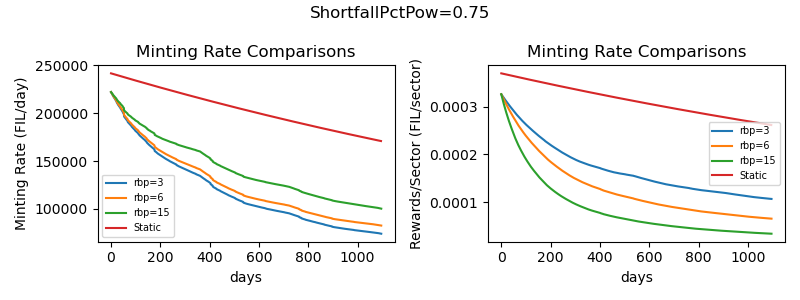

In [18]:
# Compare the various minting rate projections to better interpret the results

plt.figure(figsize=(8,3))

plt.subplot(1,2,1)
plt.plot(ob_low_sa_low['day_network_reward'], label='rbp=3')
plt.plot(ob_med_sa_low['day_network_reward'], label='rbp=6')
plt.plot(ob_hi_sa_low['day_network_reward'], label='rbp=15')
plt.plot(reward_vector, label='Static')
plt.xlabel('days')
plt.ylabel('Minting Rate (FIL/day)')
plt.title('Minting Rate Comparisons')
plt.legend(fontsize=7)

plt.subplot(1,2,2)
plt.plot(ob_low_sa_low['day_rewards_per_sector'], label='rbp=3')
plt.plot(ob_med_sa_low['day_rewards_per_sector'], label='rbp=6')
plt.plot(ob_hi_sa_low['day_rewards_per_sector'], label='rbp=15')
plt.plot(reward_per_sector, label='Static')
plt.xlabel('days')
plt.ylabel('Rewards/Sector (FIL/sector)')
plt.title('Minting Rate Comparisons')
plt.legend(fontsize=7)


plt.tight_layout()